# Train Invisible Watermark on PhotoMaker Images (100 epochs + early stopping)

Trains an encoder/decoder on real PhotoMaker outputs stored in `Code/photomaker_dataset/` with:
- Up to 100 epochs
- Early stopping on BER
- Logging (loss, BER, LPIPS)
- Trend plots
- Confusion matrix

In [1]:
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.transforms.functional as TF
from PIL import Image

try:
    import lpips
    LPIPS_AVAILABLE = True
except ImportError:
    LPIPS_AVAILABLE = False
    print("LPIPS not installed. Run `pip install lpips` for perceptual loss.")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [2]:
# Configuration
DATA_DIR = Path("/teamspace/studios/this_studio/PhotoMaker-CAP-C6-Group_3/Code/photomaker_dataset")  # folder with your PhotoMaker images
EPOCHS = 100
BATCH_SIZE = 8
LR = 1e-4
BIT_LENGTH = 64
IMAGE_SIZE = 256

ENCODER_PATH = Path("encoder_trained.pth")
DECODER_PATH = Path("decoder_trained.pth")
ENCODER_BEST_PATH = Path("encoder_best.pth")
DECODER_BEST_PATH = Path("decoder_best.pth")

# Early stopping
PATIENCE = 10

print("Using device:", DEVICE)
print("Dataset folder:", DATA_DIR.resolve())

Using device: cuda
Dataset folder: /teamspace/studios/this_studio/PhotoMaker-CAP-C6-Group_3/Code/photomaker_dataset


In [3]:
class PhotoMakerDataset(Dataset):
    def __init__(self, root, image_size=256):
        self.root = Path(root)
        exts = [".png", ".jpg", ".jpeg", ".webp"]
        self.files = [p for p in self.root.rglob("*") if p.suffix.lower() in exts]
        if not self.files:
            raise RuntimeError(f"No images found in {self.root}")

        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        img = Image.open(path).convert("RGB")
        return self.transform(img)

dataset = PhotoMakerDataset(DATA_DIR, image_size=IMAGE_SIZE)
len(dataset)

270

In [4]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
next(iter(dataloader)).shape

torch.Size([8, 3, 256, 256])

In [5]:
class WatermarkEncoder(nn.Module):
    def __init__(self, bit_length=64):
        super().__init__()
        self.bit_length = bit_length

        # 256 feature maps of size 16×16
        self.bit_fc = nn.Linear(bit_length, 256 * 16 * 16)

        self.conv = nn.Sequential(
            nn.Conv2d(3 + 256, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 1),
        )

    def forward(self, image, bits):
        B, C, H, W = image.shape

        # Correct reshape
        x = self.bit_fc(bits).view(B, 256, 16, 16)

        # Upsample to image size
        x = F.interpolate(x, size=(H, W), mode="bilinear", align_corners=False)

        # Concatenate bit features with image
        x = torch.cat([image, x], dim=1)

        # Predict residual
        residual = self.conv(x)

        return torch.clamp(image + 0.01 * residual, 0.0, 1.0)



class WatermarkDecoder(nn.Module):
    def __init__(self, bit_length=64):
        super().__init__()
        self.bit_length = bit_length

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 16 * 16, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, bit_length),
        )

    def forward(self, image):
        B, C, H, W = image.shape
        x = F.adaptive_avg_pool2d(self.conv(image), (16, 16))
        x = x.view(B, -1)
        return self.fc(x)

encoder = WatermarkEncoder(bit_length=BIT_LENGTH).to(DEVICE)
decoder = WatermarkDecoder(bit_length=BIT_LENGTH).to(DEVICE)
sum(p.numel() for p in encoder.parameters()), sum(p.numel() for p in decoder.parameters())

(4464579, 4267328)

In [6]:
import io
to_pil = T.ToPILImage()
to_tensor = T.ToTensor()

def jpeg_compress_single(img, quality=70):
    pil = to_pil(img.cpu())
    buffer = io.BytesIO()
    pil.save(buffer, format="JPEG", quality=quality)
    buffer.seek(0)
    return to_tensor(Image.open(buffer)).to(img.device)

color_jitter = T.ColorJitter(
    brightness=0.1,
    contrast=0.1,
    saturation=0.1,
    hue=0.02,
)

def apply_attacks(batch):
    attacked = []
    for img in batch:
        x = img.clone()

        # Gaussian noise
        x = x + 0.01 * torch.randn_like(x)

        # Random blur
        if torch.rand(1).item() < 0.3:
            x = TF.gaussian_blur(x, kernel_size=5)

        # Color jitter
        if torch.rand(1).item() < 0.3:
            x = color_jitter(x)

        # Resize attack
        if torch.rand(1).item() < 0.5:
            H, W = x.shape[1], x.shape[2]
            new_size = int(H * 0.7)
            x = F.interpolate(x.unsqueeze(0), size=(new_size, new_size), mode="bilinear", align_corners=False)
            x = F.interpolate(x, size=(H, W), mode="bilinear", align_corners=False).squeeze(0)

        # JPEG compression
        if torch.rand(1).item() < 0.5:
            x = jpeg_compress_single(x, quality=70)

        attacked.append(torch.clamp(x, 0.0, 1.0))

    return torch.stack(attacked)

In [7]:
if LPIPS_AVAILABLE:
    lpips_fn = lpips.LPIPS(net='vgg').to(DEVICE)
else:
    lpips_fn = None

bce_loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LR)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


In [8]:
from tqdm.auto import tqdm

def bit_error_rate(pred_bits, true_bits):
    pred = (pred_bits > 0.5).float()
    diff = (pred != true_bits).float().mean(dim=1)  # per-sample BER
    return diff.mean().item()

loss_log = []
ber_log = []
lpips_log = []

best_ber = float("inf")
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    encoder.train()
    decoder.train()

    total_loss = 0.0
    total_ber = 0.0
    total_lp = 0.0
    count = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{EPOCHS}")
    for imgs in pbar:
        imgs = imgs.to(DEVICE)
        B = imgs.size(0)

        bits = torch.randint(0, 2, (B, BIT_LENGTH), device=DEVICE).float()

        watermarked = encoder(imgs, bits)
        attacked = apply_attacks(watermarked)
        pred_bits = decoder(attacked)

        img_loss = F.mse_loss(watermarked, imgs)
        wm_loss = bce_loss(pred_bits, bits)

        if lpips_fn is not None:
            lp = lpips_fn(watermarked, imgs).mean()
        else:
            lp = torch.tensor(0.0, device=DEVICE)

        loss = img_loss + 0.1 * lp + wm_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ber = bit_error_rate(torch.sigmoid(pred_bits), bits)

        total_loss += loss.item() * B
        total_ber += ber * B
        total_lp += lp.item() * B
        count += B

        pbar.set_postfix({
            "loss": total_loss / count,
            "ber": total_ber / count,
            "lpips": total_lp / count,
        })

    epoch_loss = total_loss / count
    epoch_ber = total_ber / count
    epoch_lp = total_lp / count

    loss_log.append(epoch_loss)
    ber_log.append(epoch_ber)
    lpips_log.append(epoch_lp)

    print(f"Epoch {epoch}: loss={epoch_loss:.4f}, BER={epoch_ber:.4f}, LPIPS={epoch_lp:.4f}")

    # Early stopping on BER
    if epoch_ber < best_ber:
        best_ber = epoch_ber
        patience_counter = 0
        torch.save(encoder.state_dict(), ENCODER_BEST_PATH)
        torch.save(decoder.state_dict(), DECODER_BEST_PATH)
        print(f"  New best BER: {best_ber:.4f} (models saved)")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

Epoch 1/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1: loss=0.6932, BER=0.4937, LPIPS=0.0000
  New best BER: 0.4937 (models saved)


Epoch 2/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2: loss=0.6933, BER=0.5005, LPIPS=0.0000
  No improvement. Patience: 1/10


Epoch 3/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3: loss=0.6935, BER=0.4991, LPIPS=0.0000
  No improvement. Patience: 2/10


Epoch 4/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4: loss=0.6935, BER=0.5032, LPIPS=0.0000
  No improvement. Patience: 3/10


Epoch 5/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5: loss=0.6935, BER=0.5019, LPIPS=0.0000
  No improvement. Patience: 4/10


Epoch 6/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6: loss=0.6932, BER=0.4951, LPIPS=0.0000
  No improvement. Patience: 5/10


Epoch 7/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7: loss=0.6933, BER=0.5037, LPIPS=0.0000
  No improvement. Patience: 6/10


Epoch 8/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8: loss=0.6933, BER=0.4994, LPIPS=0.0000
  No improvement. Patience: 7/10


Epoch 9/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9: loss=0.6934, BER=0.5004, LPIPS=0.0000
  No improvement. Patience: 8/10


Epoch 10/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10: loss=0.6931, BER=0.4949, LPIPS=0.0000
  No improvement. Patience: 9/10


Epoch 11/100:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11: loss=0.6932, BER=0.4951, LPIPS=0.0000
  No improvement. Patience: 10/10
Early stopping triggered.


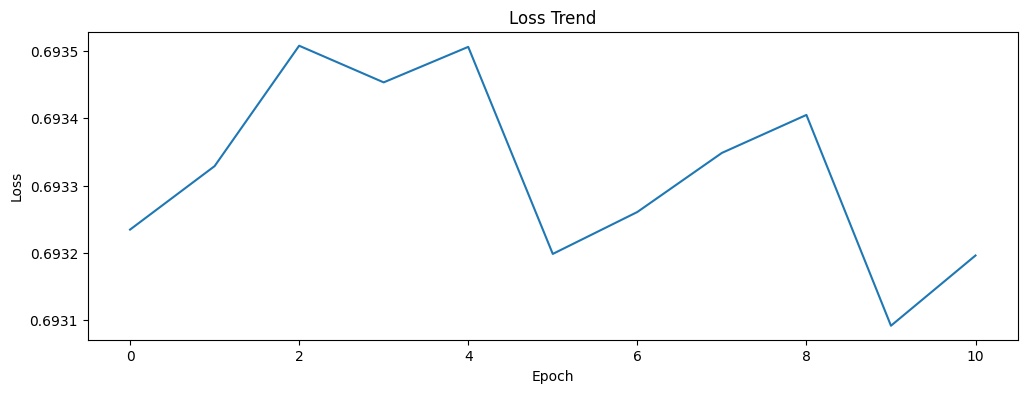

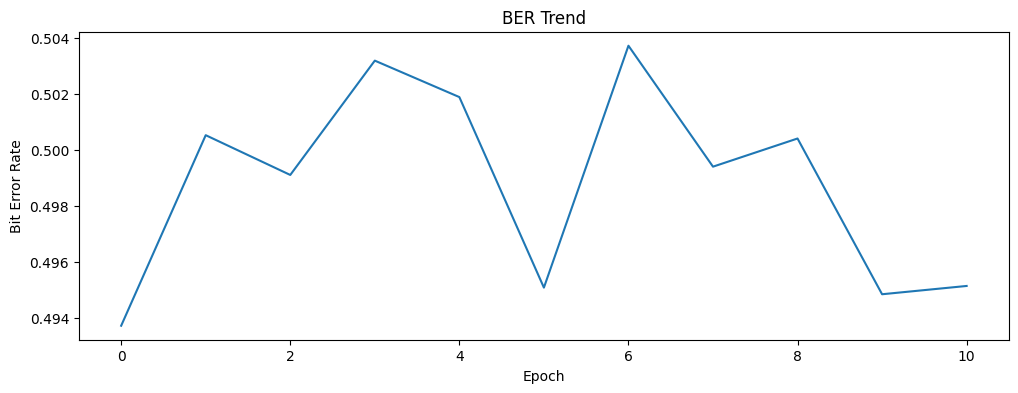

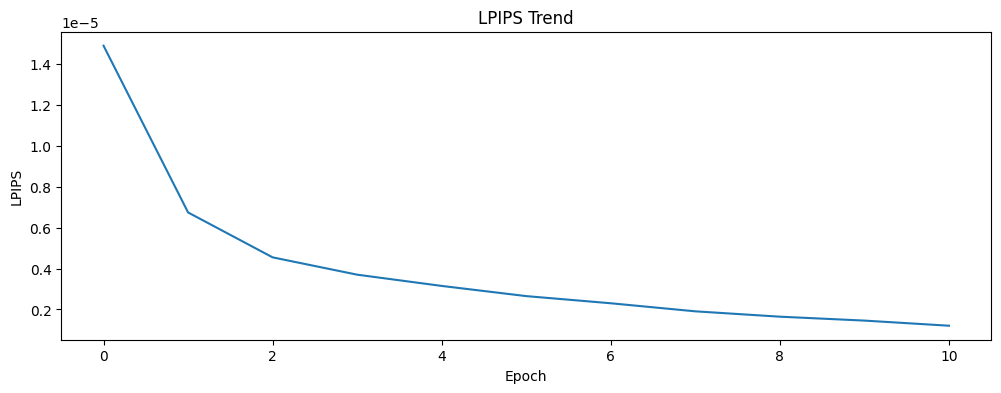

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(loss_log)
plt.title("Loss Trend")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("loss_curve.png", dpi=300)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(ber_log)
plt.title("BER Trend")
plt.xlabel("Epoch")
plt.ylabel("Bit Error Rate")
plt.savefig("loss_curve.png", dpi=300)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(lpips_log)
plt.title("LPIPS Trend")
plt.xlabel("Epoch")
plt.ylabel("LPIPS")
plt.savefig("loss_curve.png", dpi=300)
plt.show()

In [10]:
torch.save(encoder.state_dict(), ENCODER_PATH)
torch.save(decoder.state_dict(), DECODER_PATH)
print("Saved final:", ENCODER_PATH.resolve())
print("Saved final:", DECODER_PATH.resolve())
print("Best models (by BER):", ENCODER_BEST_PATH.resolve(), DECODER_BEST_PATH.resolve())

Saved final: /teamspace/studios/this_studio/PhotoMaker-CAP-C6-Group_3/Code/encoder_trained.pth
Saved final: /teamspace/studios/this_studio/PhotoMaker-CAP-C6-Group_3/Code/decoder_trained.pth
Best models (by BER): /teamspace/studios/this_studio/PhotoMaker-CAP-C6-Group_3/Code/encoder_best.pth /teamspace/studios/this_studio/PhotoMaker-CAP-C6-Group_3/Code/decoder_best.pth


In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Use best models for evaluation if available
if ENCODER_BEST_PATH.exists() and DECODER_BEST_PATH.exists():
    encoder.load_state_dict(torch.load(ENCODER_BEST_PATH, map_location=DEVICE))
    decoder.load_state_dict(torch.load(DECODER_BEST_PATH, map_location=DEVICE))
    print("Loaded best models for confusion matrix.")

encoder.eval()
decoder.eval()

with torch.no_grad():
    imgs = next(iter(dataloader)).to(DEVICE)
    B = imgs.size(0)
    bits = torch.randint(0, 2, (B, BIT_LENGTH), device=DEVICE).float()

    watermarked = encoder(imgs, bits)
    attacked = apply_attacks(watermarked)
    pred_bits = torch.sigmoid(decoder(attacked))

    pred = (pred_bits > 0.5).float().cpu().numpy().flatten()
    true = bits.cpu().numpy().flatten()

cm = confusion_matrix(true, pred)
cm

Loaded best models for confusion matrix.


array([[126, 134],
       [136, 116]])

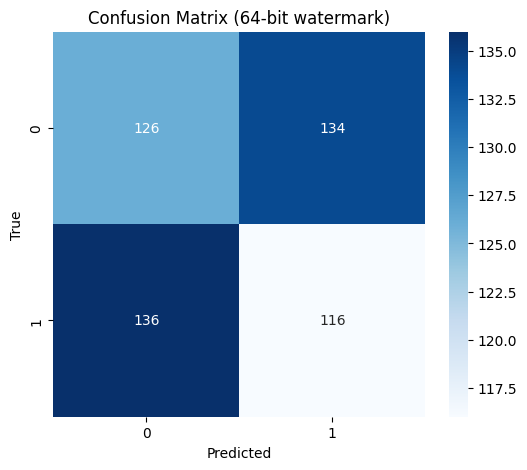

In [13]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (64-bit watermark)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()